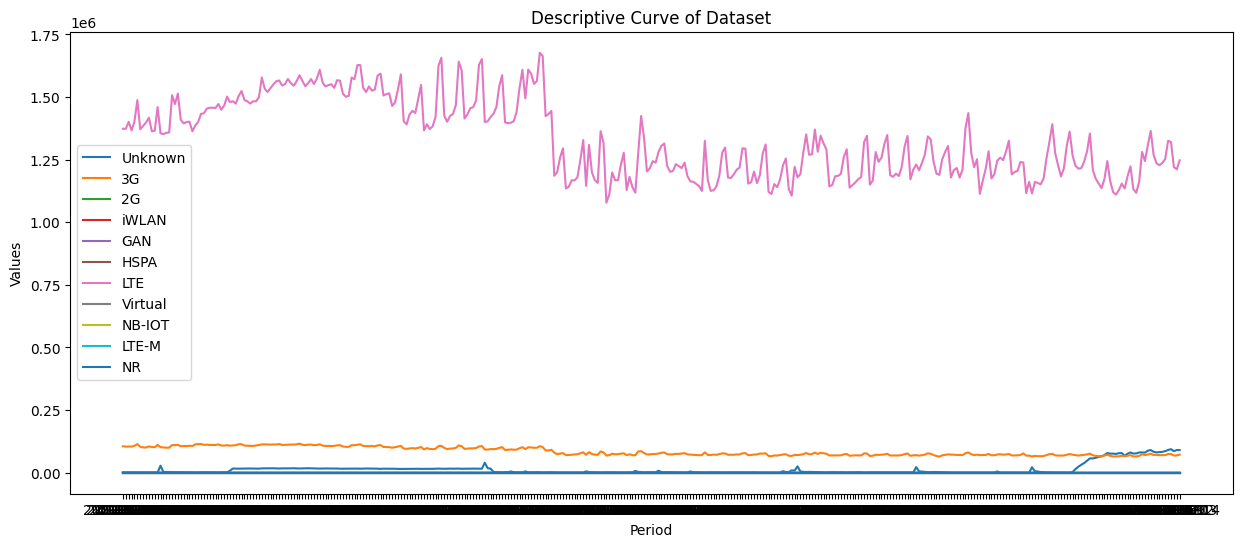

,Unknown,3G,2G,iWLAN,GAN,HSPA,LTE,Virtual,NB-IOT,LTE-M,NR
Period,,,,,,,,,,,
2022-06-14,1460.674146,105578.192316,852.242280,0.0,0.0,0.0,1.373468e+06,0.0,0.0,0.0,0.0
2022-06-15,1675.333346,104225.052095,848.608212,0.0,0.0,0.0,1.373256e+06,0.0,0.0,0.0,0.0
2022-06-16,1578.669470,104693.730108,857.836745,0.0,0.0,0.0,1.400934e+06,0.0,0.0,0.0,0.0
2022-06-17,1473.001369,104222.146377,873.967559,0.0,0.0,0.0,1.366742e+06,0.0,0.0,0.0,0.0
2022-06-18,1175.457141,107545.368594,883.748829,0.0,0.0,0.0,1.401997e+06,0.0,0.0,0.0,0.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import seasonal_decompose
    
df_list = pd.read_html('/home/fares/DatasetsOrange/offer.xls')
df = df_list[0]

df = df.set_index('Period')

float_cols = df.columns

df[float_cols] = df[float_cols].applymap(lambda x: str(x).replace(",", "."))
df[float_cols] = df[float_cols].applymap(lambda x: str(x).replace(" ", ""))
df[float_cols] = df[float_cols].apply(pd.to_numeric, errors='coerce', axis=1)
df[float_cols] = df[float_cols].applymap(lambda x: x / (1024 * 1024 * 1024))

# Increase the figure size
plt.figure(figsize=(15, 6))  # Adjust the values to increase/decrease the size

# Plotting the descriptive curve
plt.plot(df.index, df.values)
plt.xlabel('Period')
plt.ylabel('Values')
plt.title('Descriptive Curve of Dataset')
plt.legend(df.columns)
plt.show()
df.head()


In [2]:
from statsmodels.tsa.stattools import adfuller

# Select the first column for the stationarity test
column_name = df.columns[0]

# Perform the ADF test
result = adfuller(df[column_name])

# Extract and print the test statistics
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')


ADF Statistic: 1.0311631096377964
p-value: 0.9945841119961805
Critical Values:
   1%: -3.4484434475193777
   5%: -2.869513170510808
   10%: -2.571017574266393


In [ ]:
# Get the trend, seasonality, and residuals components
# Perform seasonal decomposition
decomposition = seasonal_decompose(df[column_name], period=12,model='additive')

trend = decomposition.trend
seasonality = decomposition.seasonal
residuals = decomposition.resid

# Plotting the components
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(df[column_name], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonality, label='Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residuals, label='Residuals')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
df.index = pd.to_datetime(df.index)
# Specify the order (p, d, q) parameters for the ARIMA model
# Split the dataset into a training set and a test set
train_size = int(len(df) * 0.9)  # Adjust the split ratio as desired
train_data = df[:train_size]
test_data = df[train_size:]

order = (60, 1, 10)  

# Create an instance of the ARIMA model

model = ARIMA(train_data[column_name], order=order)

# Fit the model to the data

model_fit = model.fit()
# Define the desired number of days to predict

desired_days = 150

# Generate a range of dates starting from the last date of the dataset
start_date = df.index[-1] + DateOffset(days=1)
end_date = start_date + DateOffset(days=desired_days)
prediction_dates = pd.date_range(start=start_date, end=end_date)
# Generate a range of dates starting from the last date of the dataset
start_date = df.index[-1] + DateOffset(days=1)
end_date = start_date + DateOffset(days=desired_days)
prediction_dates = pd.date_range(start=start_date, end=end_date)

# Generate predictions for the desired dates
predictions = model_fit.predict(start=prediction_dates[0], end=prediction_dates[-1])
print(predictions)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[column_name], label='Original')
plt.plot(prediction_dates, predictions, label='Predictions')
plt.xlabel('Period')
plt.ylabel('Values')
plt.title('ARIMA Model Predictions (Extended)')
plt.legend()
plt.show()
# Save the trained ARIMA model
#model_path = 'ARIMA.pkl'
#model_fit.save(model_path)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate predictions for the test set
predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

# Calculate evaluation metrics
mse = mean_squared_error(test_data[column_name], predictions)
mae = mean_absolute_error(test_data[column_name], predictions)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
